### Forest structure using PDAL + Python

Dr Adam Steer, November 2019.

This work is a set of python modules to replace MATLAB code for generating TERN forest metrics from airborne LIDAR.

## Fundamental ideas

Existing code uses a series of nested loops, meaning we can't take advantage of array operations or easily reformat or paralellise functionality

The approach used here defines a transportable function for each TERN product. These are applied to the data using a single loop (which could be chunked and parallelised).

A simple process step-through looks like:

1. Read LAS tile using PDAL. This removes an uncompression step. It also removes low outliers and computes normalised height for each point on the fly
2. Read numpy labelled arrays from PDAL output into a GeoPandas dataframe, and apply a 2D spatial index
3. From LAS file metadata, produce a fishnet grid with cells of size 'output resolution X output resolution'
4. Iterate over grid cells, select valid points and generate TERN products for each grid cell
5. Assemble an output array for each TERN product and write to GeoTIFF

This set of functions operates per-las-tile. An additional layer may be added to merge mutliple raster outputs into larger datasets

## to do:

- snake_casify variable names

In [25]:
NODATA_VALUE = -9999
LCF_HEIGHTS_ACT = [0, 0.5, 2]
LCF_HEIGHTS_NCAS = [0, 0.05, 1, 3]

In [3]:
#imports
import pdal
import numpy as np
import json

from shapely.geometry import Point
from shapely.geometry import MultiPolygon
from shapely.geometry import box
#from shapely.strtree import STRtree

import geopandas as gpd
import pandas as pd
import osmnx as ox

import os

# not using this, using geopandas instead
from rtree import index

# this is needed to create a raster from the output array
from osgeo import gdal
import osgeo.osr as osr

In [44]:
def writegeotiff(griddedpoints, outfile, parameters):
    """
    writes out a geotiff from a numpy array of forest metric
    results.
    
    inputs:
    - a numpy array of metrics [griddedpoints]
    - an outfile name [outfile]
    - a dictionary of parameters for the raster
    
    outputs:
    - a gdal dataset object
    - [outfile] written to disk
    """

    width = parameters["width"]
    height = parameters["height"]
    wktcrs = parameters["projection"]

    srs = osr.SpatialReference()
    srs.ImportFromWkt(wktcrs)

    drv = gdal.GetDriverByName("GTiff")
    ds = drv.Create(outfile, width, height, 1, gdal.GDT_Float32 )
    ds.SetGeoTransform([parameters["upperleft_x"],
                       parameters["resolution"],
                       0,
                       parameters["upperleft_y"],
                       0,
                       -parameters["resolution"]])
    ds.SetProjection(srs.ExportToWkt())
    ds.GetRasterBand(1).WriteArray(np.rot90(griddedpoints))

    ds.FlushCache()
    ds = None

    return()

def pdal2df(points):
    """
    Feed me a PDAL pipeline return array, get back a 
    GeoPandas dataframe 
    """

    arr = points[0]
    description = arr.dtype.descr
    cols = [col for col, __ in description]
    gdf = gpd.GeoDataFrame({col: arr[col] for col in cols})
    gdf.name = 'nodes'
    gdf['geometry'] = gdf.apply(lambda row: Point((row['X'], row['Y'])), axis=1)
    
    return(gdf)

def spatialindex(dataframe):
    sindex = dataframe.sindex
    return(sindex)

#get a pointview from PDAL
def readlasfile(lasfile):
    """
    Run a PDAL pipeline. Input is a JSON declaration to 
    deliver to PDAL. Output is a labelled numpy array.
    
    Data are filtered to:
    - label local minima as noise
    - compute height above ground using nearest ground point
      neighbours (TIN method arriving soon)
    - sort using a morton order (space filling curve) to 
      speed indexing later.
    
    """
    pipeline = {
        "pipeline": [
            {
                "type": "readers.las",
                "filename": lasfile
            },
            {
                "type": "filters.mortonorder"
            },
            {
                "type": "filters.hag"
            }
        ]
    }
    
    pipeline = pdal.Pipeline(json.dumps(pipeline))
    pipeline.validate()
    pipeline.loglevel = 2  # stay quiet
    count = pipeline.execute()
    
    #extract metadata into a JSON blob
    metadata = json.loads(pipeline.metadata)
    
    #read points into labelled arrays
    arrays = pipeline.arrays

    #return a numpy array to operate on
    return(metadata, arrays)

def extract_vars(df):
    """
    extract relevant variables
    do we need to do this now? or wait till we've grabbed the indexed chunk?
    lets write it anyway, then the index chunkifier can call it...
    
    inputs:
    - a numpy labelled array resulting from a PDAL LAS/LAZ file read
    
    outputs:
    - 1D arrays containing relevant variables
    
    """
    classification = df["Classification"].values
    intensity = df["Intensity"].values
    returnnumber = df["ReturnNumber"].values
    numberofreturns = df["NumberOfReturns"].values
    elevation = df["Z"].values
    hag = df["HeightAboveGround"].values

    return(intensity, returnnumber, numberofreturns, elevation, hag)


def gen_raster_cells(metadata, resolution):
    """
    Generate cells of 'resolution x resolution' for point querying
    
    input:
    - PDAL metadata
    
    output:
    - shapely geometry containing polygons defining 'resolution x resolution'
      boxes covering the LAS tile extent
      
    """
    bbox = box(metadata["metadata"]["readers.las"][0]["minx"],
               metadata["metadata"]["readers.las"][0]["miny"],
               metadata["metadata"]["readers.las"][0]["maxx"],
               metadata["metadata"]["readers.las"][0]["maxy"])
    
    tiledBBox = ox.quadrat_cut_geometry(bbox, quadrat_width=resolution)
    
    return(tiledBBox)

def get_cell_points(poly, df, sindex):
    
    poly = poly.buffer(1e-14).buffer(0)
    possible_matches_index = list(sindex.intersection(poly.bounds))
    possible_matches = df.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(poly)]
    
    return(precise_matches)

In [5]:
# Vegetation cover fraction: (Nfirst - Nsingle) / Nfirst
def comp_vcf(points):
    """
    Computes vegetation cover fraction according to the TERN product manual.
    
    inputs:
    - a labelled array of points from an input LAS tile
    
    outputs:
    - a numpy array of grid cells containing the result of:
    
    (Nfirst - Nsingle) / Nfirst
    
    ...where:
    Nfirst = count of first returns
    Nsingle = count of single returns
    
    ...per grid cell.
    """
    # collect all the first and single return indices
    nSingle = np.size(np.where(points["NumberOfReturns"].values == 1))
    nFirst = np.size(np.where(points["ReturnNumber"].values == 1))
    if (nFirst > 0):
        vcf = (nFirst - nSingle) / nFirst
    else:
        print('no first returns, set vcf to {}'.format(NODATA_VALUE))
        vcf = NODATA_VALUE
        
    return(vcf)

In [6]:
# Canopy layering index:

# R = total returns
# 

In [7]:
# vegetation layer cover fraction: LCF

def comp_lcf(points, heights, vcf):
    """
    Compute LCF as per the TERN product manual:
    
    LCF = VCF * (((veg returns below H2) - (veg returns below H1)) / (veg returns below H2))
    
    Inputs:
    - a set of points to compute LCF over
    - a height threshold pair, containing H1 and H2 as an array [h1, h2]
    - a precomputed VCF
    
    Outputs:
    - a floating point number denoting LCF
    
    Conditions:
    
    The LCF *must* be computed over the same set of points as the VCF used as input.
    
    """
    
    h1 = heights[0]
    h2 = heights[1]
    
    #find veg returns - ASPRS classes 3,4,5
    veg_returns = np.where(np.logical_or(points["Classification"].values == 3,
                             points["Classification"].values == 4,
                             points["Classification"].values == 5))
    # how many veg returns have height below the first threshold?
    vegbelowh1 = np.size(np.where(points["HeightAboveGround"][vegreturns] < h1))
    
    # how many veg returns have height below the second threshold?
    vegbelowh2 = np.size(np.where(points["HeightAboveGround"][vegreturns] < h2))
    
    # compute the LCF
    lcf = vcf * ( (vegbelowh2 - vegbelowh1) / vegbelowh2)
    
    return(lcf)


In [88]:
#CTH - TERN product manual says 'highest vegetation point', MATLAB code says '0.95 quantile of
# vegetation returns above 2m'. Below 2m is ignored

def comp_cth(points):
    # compute the highest vegetation point in each grid cell
    
    veg_returns = np.where(np.logical_or(points["Classification"].values == 3,
                             points["Classification"].values == 4,
                             points["Classification"].values == 5))

    try:
        vegpoints = points["HeightAboveGround"].values[veg_returns]
        canopy_index = np.where(vegpoints > 2.0)
        if (np.size(canopy_index) > 0):
            cth = np.quantile(vegpoints[canopy_index], 0.95)
        else:
            cth = NODATA_VALUE
                
    except ValueError:
        #print('no vegetation returns were present, CTH set to {}'.format(NODATA_VALUE))
        cth = NODATA_VALUE

    return(cth)

In [89]:
#CBH - ambiguous in TERN docs, will pull from MATLAB code
# there, it states that CBH is the 0.1th percentile of vegetation with normalised height
# above 2m
def comp_cbh(points):
    # compute the canopy base height in each cell.
    
    # grab an index of vegetation returns
    veg_returns = np.where(np.logical_or(points["Classification"].values == 3,
                             points["Classification"].values == 4,
                             points["Classification"].values == 5))
    try:
        #create an array of vegetation point normalised heights
        vegpoints = points["HeightAboveGround"].values[veg_returns]
        canopy_index = np.where(vegpoints > 2.0)
        if(np.size(canopy_index) > 0 ):
            #find the 0.1 quantile
            cbh = np.quantile(vegpoints[canopy_index], 0.10)
        else:
            cbh = NODATA_VALUE
    
    except ValueError:
        #if there are no veg points, set cth to NODATA
        
        #print('no vegetation returns were present, CTH set to {}'.format(NODATA_VALUE))
        cbh = NODATA_VALUE

    return(cbh)

In [90]:
def comp_dem(points):
    # interpolate ground returns in a grid and output a raster
    
    
    return()

In [10]:
def comp_fbf(points):
    # if building classes exist, compute a fractional conver per grid cell...
    # if no buildings exist return 0
    
    building_returns = np.where(points["Classification"].values == 6)
    
    totalpoints = np.size(points["Classification"])
    
    buildingpoints = np.size(building_returns)
    
    if (buildingpoints > 0):
        fbf = buildingpoints/totalpoints
    else:
        fbf = 0
        
    return(fbf)

In [26]:
def read_data(lasfile):
    """
    wrapper to read in LAS data and produce a dataframe + spatial index
    """
    metadata, points = readlasfile(lasfile)
    
    dataframe, spatial_index = pdal2df(points)
    
    return(metadata, dataframe, spatial_index)
    

In [31]:
def make_file_rootname(lasfile):
    filebits = lasfile.split("/")
    infilename = filebits[-1]
    fileroot = infilename[:-4]
    return(fileroot)

In [73]:
def compute_tern_products(metadata, points, sindex, resolution, lasfile, outpath):
    """
    Wrapper to iterate over the input data and generate rasters for each product.
    
    *note this part could be paralellised - maybe per-product, or per-cell
    
    Each grid square processed in this loop corresponds to one pixel in an output raster.
    
    """
    
    #set up an 'output resolution' sized grid - like a fishnet grid.
    # each polygon in the resulting set covers an area of 'resolution X resolution'
    pixel_grid = gen_raster_cells(metadata, resolution)
    
    #set up output rasters
    
    # get tile width and height
    tile_width = metadata["metadata"]["readers.las"][0]["maxx"] - metadata["metadata"]["readers.las"][0]["minx"]
    tile_height = metadata["metadata"]["readers.las"][0]["maxy"] - metadata["metadata"]["readers.las"][0]["miny"]

    raster_xsize = int(np.ceil(tile_width) / resolution)
    raster_ysize = int(np.ceil(tile_height) / resolution)
    
    #replicate for all products...
    vcf_raster = np.zeros((raster_xsize, raster_ysize))
    lcf_raster = np.zeros((raster_xsize, raster_ysize))
    cth_raster = np.zeros((raster_xsize, raster_ysize))
    cbh_raster = np.zeros((raster_xsize, raster_ysize))
    fbf_raster = np.zeros((raster_xsize, raster_ysize))
    
    #internal loop around grid squares covering the LAS tile.
    # this is another ppoint for parallelisation - since we can set up a list of geometries
    # and cast that at multipuple processes, setting up one process per grid square
    # another way to do this would be to recast this loop block into a function which can  
    # be called by one process per product
    # the second strategy seems easier, then only one process is trying to write into each
    # output array.
    
    for pixel in pixel_grid:
        
        #compute output array index for this cell:
        poly_x, poly_y = pixel.centroid.xy
        
        poly_base_x = poly_x[0] - metadata["metadata"]["readers.las"][0]["minx"]
        poly_base_y = poly_y[0] - metadata["metadata"]["readers.las"][0]["miny"]
        
        array_x = int(np.floor((poly_base_x / (resolution)) ))
        array_y = int(np.floor((poly_base_y / (resolution)) ))
                
        #get points for this cell
        matches = get_cell_points(pixel, points, sindex)
        
        #compute in order
        #VCF
        vcf_raster[array_x, array_y] = comp_vcf(matches)
        
        
        #LCF - need stuff about levels here...
        #lcf_raster[array_x, array_y] = comp_lcf(points)
        
        #CTH
        cth_raster[array_x, array_y] = comp_cth(matches)
        
        #CBH
        cth_raster[array_x, array_y] = comp_cth(matches)
        
        #FBF
        fbf_raster[array_x, array_y] = comp_fbf(matches)
        
        
    #end of computing stuff, time to make outputs...
    
    #set up GDAL parameters
    
    wktcrs = metadata["metadata"]["readers.las"][0]["comp_spatialreference"]
    
    raster_parameters = {}
    raster_parameters["width"] = np.shape(vcf_raster)[0]
    raster_parameters["height"] = np.shape(vcf_raster)[1]
    raster_parameters["upperleft_x"] = metadata["metadata"]["readers.las"][0]["minx"]
    raster_parameters["upperleft_y"] = metadata["metadata"]["readers.las"][0]["maxy"]
    raster_parameters["resolution"] = resolution
    raster_parameters["projection"] = wktcrs
    
    if (not os.path.isdir(outpath + "/vcf")):
        os.mkdir(outpath + "/vcf")
    if (not os.path.isdir(outpath + "/cth")):
        os.mkdir(outpath + "/cth")
    if (not os.path.isdir(outpath + "/cbh")):
        os.mkdir(outpath + "/cbh")
    if (not os.path.isdir(outpath + "/fbf")):
        os.mkdir(outpath + "/fbf")
        
    fileroot = make_file_rootname(lasfile)

    #set output filenames
    vcf_raster_path = outpath + "/vcf/" + fileroot + "-VCF-" + str(resolution) + "m.tiff"
    cth_raster_path = outpath + "/cth/" + fileroot + "-CTH-" + str(resolution) + "m.tiff"
    cbh_raster_path = outpath + "/cth/" + fileroot + "-CTH-" + str(resolution) + "m.tiff"
    fbf_raster_path = outpath + "/fbf/" + fileroot + "-FBF-" + str(resolution) + "m.tiff"
    #write geotiffs and return arrays for inspection...

    writegeotiff(vcf_raster, vcf_raster_path, raster_parameters)
    writegeotiff(cth_raster, cth_raster_path, raster_parameters)
    writegeotiff(cbh_raster, cbh_raster_path, raster_parameters)
    writegeotiff(fbf_raster, fbf_raster_path, raster_parameters)
    
    tern_products = {}
    tern_products["vcf"] = vcf_raster
    tern_products["cth"] = cth_raster
    tern_products["cbh"] = cth_raster
    tern_products["fbf"] = fbf_raster
    
    return(tern_products)

## Testing functionality using a local file
The following section generates metrics from a local LAZ file. Plugging in download mechanics from ELVIS will be added later

In [13]:
#lidar test file - Mt Ainslie, chosen for varied vegetation cover and topography
# this is pretty big, try it out if you've got more resources than my macbook pro!

#lasfile = "/Volumes/Antares/ACT-lidar/8ppm/callingelvis-testdata/ACT2015_8ppm-C3-AHD_6966094_55.laz"

In [14]:
#lasfile = "/Volumes/Antares/fire-test/NSW Government - Spatial Services-2/Point Clouds/AHD/StAlbans201709-LID2-C3-AHD_2866308_56_0002_0002/StAlbans201709-LID2-C3-AHD_2866308_56_0002_0002.las"

In [15]:
lasfile = "./Berridale201802-LID2-C3-AHD_6585974_55_0002_0002.las"

In [16]:
# dump everything from memory
points = None
df = None
vcf_raster = None
cth_raster = None
fbf_raster = None

In [17]:
%%time
# this part of the process is simply reading from the source file. No analysis yet.

metadata, points = readlasfile(lasfile)

CPU times: user 12.1 s, sys: 349 ms, total: 12.4 s
Wall time: 12.4 s


In [18]:
# uncomment to examine LAS metadata
#metadata

In [19]:
%%time

#here we read points into a GeoDataFrame and dump the labelled array.
# this is a pretty expensive step RAM wise, we're duplicating all the points...

df = pdal2df(points)

# set the points structured array to None, it isn't used anymore
points = None

CPU times: user 1min 24s, sys: 1.6 s, total: 1min 26s
Wall time: 1min 26s


In [20]:
%%time

# here we generate an RTree index on the dataframe using GeoPandas.
# also pretty expensive... 

sindex = spatialindex(df)

CPU times: user 2min 3s, sys: 1.63 s, total: 2min 4s
Wall time: 2min 5s


In [22]:
# set an output resolution

resolution = 25

In [91]:
%%time

#produce some rasters!

tern_products = compute_tern_products(metadata, df, sindex, resolution, lasfile, "../../")

CPU times: user 43.7 s, sys: 2.01 s, total: 45.7 s
Wall time: 46 s


In [79]:
this = np.array([1,2,3,4,6])

In [82]:
that = np.where(this > 7.0)

In [87]:
np.size(that)

0

In [92]:
from matplotlib import pyplot as plt

%matplotlib inline

Text(0.5, 1.0, 'Vegetation cover fraction (VCF)')

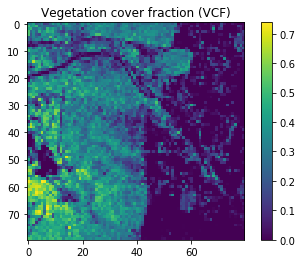

In [93]:
plt.imshow(np.rot90(tern_products["vcf"]))
plt.colorbar()
plt.title("Vegetation cover fraction (VCF)")

Text(0.5, 1.0, 'Canopy top height (CTH)')

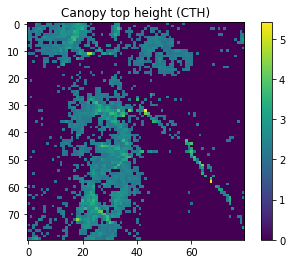

In [94]:
plt.imshow(np.rot90(tern_products["cth"]), vmin = 0)
plt.colorbar()
plt.title("Canopy top height (CTH)")


Text(0.5, 1.0, 'Building fraction (FBF)')

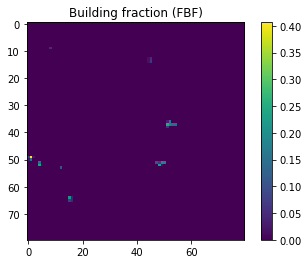

In [95]:
plt.imshow(np.rot90(tern_products["fbf"]))
plt.colorbar()
plt.title("Building fraction (FBF)")

## code purgatory

In [21]:

# an attempt at building an index without pandas. Pandas was far easier
"""
%%time


## rtree index building straight from the point dataset... which also duplicates the point set...

idx = index.Index()
for pid, point in enumerate(points[0]):
    idx.insert(pid, (point[0], point[1],point[0], point[1]), point)
"""

'\n%%time\n\n\n## rtree index building straight from the point dataset... which also duplicates the point set...\n\nidx = index.Index()\nfor pid, point in enumerate(points[0]):\n    idx.insert(pid, (point[0], point[1],point[0], point[1]), point)\n'